# Read and process bmmflux output

Bsared on a test script for quick-looking bmmflux output based on W. Babel's R scripts. The original version is included in this repo as the notebook `UBT_SummerSchool.read_bmmflux_output`

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirData = dirPre + 'data/land_station_eddycovar_2m/'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'data/land_station_eddycovar_2m_processed/'

In [3]:
# In order to keep bmmflux from crashing I had to break the analyis up into
# chunks. Each chunk is labeled according to the time period (DOY) that it covers.
filenameSuffix = ['247', '247_5', '248', '248_5']
os.chdir(dirData)


In [4]:
# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)

## Formatting the conditional surface fluxes
- I must have done something in the parameter files to have this turned off. My guess this occured when I disabled the covariance spectrum between w' and the gas analysis.

## Formatting the filestatistics

In [5]:
allFileStats = ['VHSRE_filestatistics_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
                for DOY in filenameSuffix]
fStats = pd.DataFrame()
fStats_list = []
for files in allFileStats:
    df = pd.read_csv(files, header=[0, 1], delimiter=',',
                                    index_col=1, parse_dates=[1])
    # Drop datetime_end column
    df.drop(df.columns.values[1], axis=1, inplace=True)
    fStats_list.append(df)
fStats = pd.concat(fStats_list)

# All columns are unitless, drop units row. I'm using a super hacky approach,
# it would be good to clean this up later.
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)
fStats.columns = [fS[0] for fS in fStats.columns]
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)

## Formatting QA/QC

In [6]:
all_qaqc = ['VHSRE_qaqc_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
            for DOY in filenameSuffix]
qaqc_df = pd.DataFrame()
qaqc_list = []
for qFiles in all_qaqc:
    print(qFiles)
    df = pd.read_csv(qFiles, header=0, delimiter=',', index_col='Datetime_center')
    # Drop datetime_end column
    df.drop(['Datetime_start', 'Datetime_end', 'DOY'], axis=1, inplace=True)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    qaqc_list.append(df)
qaqc_df = pd.concat(qaqc_list)

# Save units as separate dictionary
qaqc_units = qaqc_df.iloc[0]
for qu in qaqc_units.keys():
    if '[1]' in qaqc_units[qu]:
        qaqc_units[qu] = 'unitless'
qaqc_df.drop([qaqc_df.index[0]], inplace=True)


VHSRE_qaqc_1s_3Drot_frc_DOY247.csv


/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


VHSRE_qaqc_1s_3Drot_frc_DOY247_5.csv
VHSRE_qaqc_1s_3Drot_frc_DOY248.csv
VHSRE_qaqc_1s_3Drot_frc_DOY248_5.csv


In [7]:
plotFlag = False
if plotFlag:
    fig, axes = plt.subplots(6, 3, sharex=True, figsize=(15, 15))
    axes = axes.flatten()

    siteMetaData = ['Latitude', 'Coriolis_param f']
    qaqcPlotItems = [col for col in qaqc_df.columns if col not in siteMetaData]

    for n, q in enumerate(qaqcPlotItems):
        ax = axes[n]
        ax.plot(qaqc_df.index, qaqc_df[q])
        ax.set_ylabel(q + qaqc_units[q])
        ax.set_title(q)
    fig.autofmt_xdate()
    fig.tight_layout()

## Format results

In [8]:
# File names
allResults = ['VHSRE_results_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
              for DOY in filenameSuffix]

# Units (names + units = first two rows)
results_cols = pd.read_csv(allResults[0], header=0, delimiter=',',
                           error_bad_lines=False, warn_bad_lines=False, nrows=2)
results_units = results_cols.iloc[0]

# Read all data
resultsList = []

# Loop through files
for rFiles in allResults:
    print(rFiles)
    df = pd.read_csv(rFiles, header=None, delimiter=',', skiprows=[0,1],
                     names=results_cols.columns.values, index_col=False)
    # Drop datetime_end column
    df.drop(['Datetime_start', 'Datetime_end', 'DOY'],
            axis=1, inplace=True)
    resultsList.append(df)
results_df = pd.concat(resultsList)
results_df = results_df.reset_index(drop=True).\
                set_index([matlabdn2datetime(results_df['Datetime_center'].values)])
results_df.drop(['Datetime_center'], axis=1, inplace=True)
results_df.sort_index(inplace=True)

 # Save units as separate dictionary
for ru in results_units.keys():
    if '[1]' in results_units[ru]:
        results_units[ru] = 'unitless'

VHSRE_results_1s_3Drot_frc_DOY247.csv
VHSRE_results_1s_3Drot_frc_DOY247_5.csv
VHSRE_results_1s_3Drot_frc_DOY248.csv
VHSRE_results_1s_3Drot_frc_DOY248_5.csv


In [9]:
siteMetaData = ['z_asl', 'lat', 'lon', 'utc_offset', 'zenith', 'azimuth', 'z_aero',
                'DayNightIndicator', '#_data', '#_NaN_uvwTs', 'frc_#iterations', '#_lag_wTs']
resultsPlotItems = [col for col in results_df.columns if col not in siteMetaData]

if plotFlag:
    for n, r in enumerate(resultsPlotItems):
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5))
        ax.plot(results_df.index, results_df[r])
        ax.set_ylabel(r + ' (' + results_units[r]  + ')')
        ax.set_title(r)
        fig.autofmt_xdate()
        fig.tight_layout()

In [10]:
# Remove duplicate time steps
results_df = results_df[~results_df.index.duplicated(keep='first')]

# For easier handling, just keep a couple fields for the time being
fieldsKeep = ['w_mean_rot', 'Ts_mean']

# Convert to xarray Dataset
results = xr.Dataset.from_dataframe(results_df[fieldsKeep])
results.rename({'index': 'time'}, inplace=True)
# results.time.attrs['units'] = 'hours since 2000-01-01'
# Still to do
# - add units as an attribute
# - add metadata as an attribute 
print(results)

# save to a netcdf file
os.chdir(dirProcessed)
results.to_netcdf('VHRSE.eddyCovarObs_2m_land.nc')


<xarray.Dataset>
Dimensions:     (time: 140400)
Coordinates:
  * time        (time) datetime64[ns] 2017-09-04T00:00:00.518404 ...
Data variables:
    w_mean_rot  (time) float64 2.6e-05 -1.1e-05 -8e-06 1.2e-05 0.000245 0.0 ...
    Ts_mean     (time) float64 12.67 12.64 12.18 12.35 12.53 12.29 12.16 ...


## The encoding of the datetime for the netcdf is broken.

Will need to go back and look at the solution Joe sent me a while back. It might also be time to raise an issue on github regarding this issue.

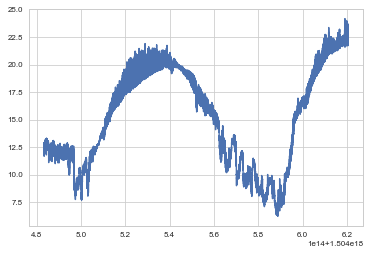

In [11]:
# Experimenting with the encoding for time
results.time.encoding['units'] = 'days since 1900-01-01'
results.time.encoding['calendar'] = 'standard'

# save the newly encoded data to a netcdf file
os.chdir(dirProcessed)
results.to_netcdf('VHRSE.eddyCovarObs_2m_land.nc')

# Open and see if the problem is fixed
os.chdir(dirProcessed)
ecObs = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.nc')
plt.plot(ecObs.time, ecObs.Ts_mean)